In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from DLC_for_WBFM.utils.projects.finished_project_data import ProjectData
import napari
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from collections import defaultdict
import zarr
import seaborn as sns

from DLC_for_WBFM.utils.nn_utils.model_image_classifier import NeuronEmbeddingModel, SiameseNeuronEmbeddingModel
from DLC_for_WBFM.utils.nn_utils.data_loading import NeuronImageFeaturesDataModule, FullVolumeNeuronImageFeaturesDataset, TripletNeuronImageFeaturesDataset
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb
from DLC_for_WBFM.utils.nn_utils.worm_with_classifier import WormWithNeuronClassifier
from DLC_for_WBFM.utils.nn_utils.utils_testing import test_trained_classifier, plot_accuracy, test_trained_embedding_matcher
from DLC_for_WBFM.utils.nn_utils.fdnc_predict import template_matches_to_dataframe

from DLC_for_WBFM.utils.nn_utils.worm_with_classifier import PATH_TO_SUPERGLUE_TRACKLET_MODEL
from DLC_for_WBFM.utils.nn_utils.superglue import SuperGlueFullVolumeNeuronImageFeaturesDatasetFromProject, SuperGlueModel
from DLC_for_WBFM.utils.nn_utils.data_loading import NeuronImageFeaturesDataModuleFromMultipleProjects
from DLC_for_WBFM.utils.nn_utils.worm_with_classifier import PATH_TO_SUPERGLUE_MODEL


Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
torch.cuda.is_available()

True

# Load 4 projects, only one with complete tracks

In [3]:
fname = "/home/charles/dlc_stacks/worm1_for_students/project_config-workstation.yaml"
project_data1 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile


File for mode automatic exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/worm1_for_students/3-tracking/postprocessing/combined_3d_tracks---12.h5
ConfigFile  : INFO     Starting threads to read data...


ConfigFile  : INFO     Read all data from files: ['/home/charles/dlc_stacks/worm1_for_students/3-tracking/postprocessing/combined_3d_tracks---12.h5', '/scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31_worm1_Ch0/2022-01-27_19-31_worm1_Ch0bigtiff.zarr.zip', '/scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31_worm1_Ch1/2022-01-27_19-31_worm1_Ch1bigtiff.zarr.zip', '/home/charles/dlc_stacks/worm1_for_students/4-traces/red_traces.h5', '/home/charles/dlc_stacks/worm1_for_students/4-traces/green_traces.h5', '/home/charles/dlc_stacks/worm1_for_students/2-training_data/training_data_tracks.h5', '/home/charles/dlc_stacks/worm1_for_students/2-training_data/reindexed_masks.zarr', '/home/charles/dlc_stacks/worm1_for_students/1-segmentation/masks3d.zarr', '/home/charles/dlc_stacks/worm1_for_students/4-traces/reindexed_masks.zarr', '/home/charles/dlc_stacks/worm1_for_students/3-tracking/manual_annotation/manual_behavior_annotation.xlsx']
ConfigFil

In [4]:
# project_data1.__dict__.keys()

In [5]:
# Same project, but remote = most updated
# fname = "/home/charles/dlc_stacks/students-worm4-reanalysis/project_config-workstation.yaml"
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/project_config.yaml"
project_data2 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
ConfigFile  : INFO     Set up logger with name: ConfigFile


File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/3-tracking/postprocessing/combined_3d_tracks-3.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     Starting threads to read data...


ConfigFile  : INFO     Read all data from files: ['/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/3-tracking/postprocessing/combined_3d_tracks-3.h5', '/scratch/neurobiology/zimmer/Charles/dat_for_students/worm4/2022-01-27_21-26_worm4_Ch0bigtiff.zarr', '/scratch/neurobiology/zimmer/Charles/dat_for_students/worm4/2022-01-27_21-26_worm4_Ch1bigtiff.zarr', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/4-traces/red_traces.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/4-traces/green_traces.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/2-training_data/training_data_tracks.pickle', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/2-training_data/reindexed_masks.zarr', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round1_worm4/1-segmentation/masks.zarr', '/scratch/neurobiology/zimmer/Charles/dlc_s

In [6]:
fname = "/home/charles/dlc_stacks/round2-worm6-short-newseg/project_config-workstation.yaml"
project_data3 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
ConfigFile  : INFO     Set up logger with name: ConfigFile


File for mode automatic exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/round2-worm6-short-newseg/3-tracking/postprocessing/combined_3d_tracks---12.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     Starting threads to read data...


ConfigFile  : INFO     Read all data from files: ['/home/charles/dlc_stacks/round2-worm6-short-newseg/3-tracking/postprocessing/combined_3d_tracks---12.h5', '/home/charles/Current_work/data/round2-worm6-short/2022-02-23_18-27_worm_6_Ch0bigtiff.zarr', '/home/charles/Current_work/data/round2-worm6-short/2022-02-23_18-27_worm_6_Ch1bigtiff.zarr', '/home/charles/dlc_stacks/round2-worm6-short-newseg/4-traces/red_traces.h5', '/home/charles/dlc_stacks/round2-worm6-short-newseg/4-traces/green_traces.h5', '/home/charles/dlc_stacks/round2-worm6-short-newseg/2-training_data/training_data_tracks.pickle', '/home/charles/dlc_stacks/round2-worm6-short-newseg/2-training_data/reindexed_masks.zarr', '/home/charles/dlc_stacks/round2-worm6-short-newseg/1-segmentation/masks.zarr', '/home/charles/dlc_stacks/round2-worm6-short-newseg/4-traces/reindexed_masks.zarr', '/home/charles/dlc_stacks/round2-worm6-short-newseg/3-tracking/manual_annotation/manual_behavior_annotation.xlsx']
ConfigFile  : INFO     Read all

In [7]:
# REMOTE
fname = "/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/project_config.yaml"
project_data4 = ProjectData.load_final_project_data_from_config(fname)

ConfigFile  : INFO     Set up logger with name: ConfigFile
ConfigFile  : INFO     Set up logger with name: ConfigFile


File for mode automatic exists at precendence: 1/3
Read data from: /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks--11.h5
ConfigFile  : INFO     Starting threads to read data...
ConfigFile  : INFO     Starting threads to read data...


ConfigFile  : INFO     Read all data from files: ['/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks--11.h5', '/scratch/neurobiology/zimmer/ulises/wbfm/20220223/data/worm3/2022-02-23_17-22_worm3_1_Ch0/2022-02-23_17-22_worm3_1_Ch0bigtiff-num_frames2050.zarr', '/scratch/neurobiology/zimmer/ulises/wbfm/20220223/data/worm3/2022-02-23_17-22_worm3_1_Ch1/2022-02-23_17-22_worm3_1_Ch1bigtiff-num_frames2050.zarr', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/4-traces/red_traces.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/4-traces/green_traces.h5', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/2-training_data/training_data_tracks.pickle', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/2-training_data/reindexed_masks.zarr', '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manuall

# Correct the projects

In [22]:
from DLC_for_WBFM.utils.projects.utils_redo_steps import correct_tracks_dataframe_using_project

In [23]:
df1 = correct_tracks_dataframe_using_project(project_data1, overwrite=False)
project_data1.final_tracks = df1

  0%|          | 0/142 [00:00<?, ?it/s]

Original fname /home/charles/dlc_stacks/worm1_for_students/3-tracking/postprocessing/combined_3d_tracks---12.h5 exists, so will be suffixed
Removed suffix -12, so the basename is taken as: combined_3d_tracks--
ConfigFile  : INFO     Saving at: 3-tracking/postprocessing/combined_3d_tracks-----12.h5
ConfigFile  : INFO     Saving at: 3-tracking/postprocessing/combined_3d_tracks-----12.h5


In [24]:
project_data1.final_tracks = df1

In [25]:
df2 = correct_tracks_dataframe_using_project(project_data2, overwrite=False)
project_data2.final_tracks = df2

  0%|          | 0/164 [00:00<?, ?it/s]

No updates needed


In [26]:
df3 = correct_tracks_dataframe_using_project(project_data3, overwrite=False)
project_data3.final_tracks = df3

  0%|          | 0/165 [00:00<?, ?it/s]

No updates needed


In [27]:
df4 = correct_tracks_dataframe_using_project(project_data4, overwrite=False)
project_data4.final_tracks = df4

  0%|          | 0/162 [00:00<?, ?it/s]

Original fname /scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks--11.h5 exists, so will be suffixed
Removed suffix -11, so the basename is taken as: combined_3d_tracks-
ConfigFile  : INFO     Saving at: 3-tracking/postprocessing/combined_3d_tracks--10.h5
ConfigFile  : INFO     Saving at: 3-tracking/postprocessing/combined_3d_tracks--10.h5


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 444, in H5Fcreate
    unable to create file
  File "H5Fint.c", line 1364, in H5F__create
    unable to open file
  File "H5Fint.c", line 1557, in H5F_open
    unable to open file: time = Fri Jun  3 11:37:53 2022
, name = '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks--10.h5', tent_flags = 13
  File "H5FD.c", line 734, in H5FD_open
    open failed
  File "H5FDsec2.c", line 350, in H5FD_sec2_open
    unable to fstat file, errno = 116, error message = 'Stale file handle'

End of HDF5 error back trace

Unable to open/create file '/scratch/neurobiology/zimmer/Charles/dlc_stacks/manually_annotated/round2_worm3/3-tracking/postprocessing/combined_3d_tracks--10.h5'

## Correctly set the subset of time and neurons for the actually correct ones

In [8]:
project_data1.finished_neurons_column_name = 'Finished?'
project_data2.finished_neurons_column_name = 'Reanalysis finished' # worm 4
project_data3.finished_neurons_column_name = 'first 100 frames' # round2 worm 6
project_data4.finished_neurons_column_name = 'Finished' # round2 worm 3

In [9]:
project_data1._custom_frame_indices = list(range(1000, 3000)) # round1 worm 1; do not include the non-moving portion
# project_data2.num_frames = 100 # worm 4; now finished!
project_data3.num_frames = 100 # round2 worm 6

# Spatial-only training setup

In [29]:
base_dataset_class = SuperGlueFullVolumeNeuronImageFeaturesDatasetFromProject
batch_size = 1
max_epochs = 30
gpus = 1
dataset_kwargs=dict(num_to_calculate=200, use_only_spatial_information=True)

all_project_data = [project_data1, project_data2, project_data3, project_data4]

In [30]:
train_loader = NeuronImageFeaturesDataModuleFromMultipleProjects(batch_size=batch_size, 
                                                                 all_project_data=all_project_data,
                                                                 base_dataset_class=base_dataset_class, 
                                                                 dataset_kwargs=dataset_kwargs) # Calculates from each project
train_loader.setup()

Precaculating training data


  0%|          | 0/200 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/200 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/200 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
# %debug

In [32]:
# Start from pretrained
# model = SuperGlueModel.load_from_checkpoint(PATH_TO_SUPERGLUE_MODEL)
model = SuperGlueModel(feature_dim=840, lr=1e-5)
model.lr = 1e-5

# Actually train

In [33]:
with wandb.init(project="superglue_training_multiple_projects_spatial_only", entity="charlesfieseler") as run:
    wandb_logger = WandbLogger()

    trainer = Trainer(gpus=gpus, max_epochs=max_epochs, terminate_on_nan=True, 
                      stochastic_weight_avg=True,
                      logger=wandb_logger,
                      val_check_interval=0.25)
    wandb_logger.watch(model, log='all', log_freq=1)
    
    trainer.fit(model, train_loader)

wandb: wandb version 0.12.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:59: LightningDeprecationWarning: Setting `Trainer(stochastic_weight_avg=True)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.stochastic_weight_avg.StochasticWeightAveraging` directly to the Trainer's `callbacks` argument instead.
  "Setting `Trainer(stochastic_weight_avg=True)` is deprecated in v1.5 and will be removed in v1.7."
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:527: LightningDeprecationWarning: Trainer argument `terminate_on_nan` was deprecated in v1.5 and will be removed in 1.7. Please use `Trainer(detect_anomaly=True)` instead.
  "Trainer argument `terminate_on_nan` was deprecated in v1.5 and will be removed in 1.7."
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/charles/anaconda3/envs/

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/callbacks/progress/base.py:211: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  UserWarning,


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


False Negative (fraction of gt),█▆▃▃▄▃▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
False Positive (fraction of gt),▁▃█▅▄▄▆▅▄▄▄▄▄▄▄▄▅▄▃▄▄▄▃▄▄
No ground truth (fraction of detections),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
True Positive (fraction of gt),▁▂▄▄▄▅▆▆▆▇▇▇▇▇▇▇▆▇██▇███▇
epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▃▂▄█▃▄▃▂▄▂▅▂▂▁▃▂▄▁▁▁▂▂▃▂▁▁▂▂▁▁▁▁▁▁▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▇▅█▄▃▂▃▂▁▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁
False Negative (fraction of gt),0.11581
False Positive (fraction of gt),0.27381
No ground truth (fraction of detections),0.34032


In [34]:
# %debug

In [35]:
model_fname = f'superglue_spatial_only_same_size.ckpt'
trainer.save_checkpoint(model_fname)

# Same, but a smaller network

In [117]:
base_dataset_class = SuperGlueFullVolumeNeuronImageFeaturesDatasetFromProject
batch_size = 1
max_epochs = 30
gpus = 1
dataset_kwargs=dict(num_to_calculate=1000, use_only_spatial_information=True)

all_project_data = [project_data1, project_data2, project_data3, project_data4]

In [118]:
train_loader = NeuronImageFeaturesDataModuleFromMultipleProjects(batch_size=batch_size, 
                                                                 all_project_data=all_project_data,
                                                                 base_dataset_class=base_dataset_class, 
                                                                 dataset_kwargs=dataset_kwargs) # Calculates from each project
train_loader.setup()

Precaculating training data


  0%|          | 0/1000 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/1000 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/1000 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
# %debug

In [120]:
# Start from pretrained
# model = SuperGlueModel.load_from_checkpoint('superglue_neurons_spatial_small.ckpt')
model_kwargs = dict(keypoint_encoder=[32], to_normalize_keypoints=False)
model = SuperGlueModel(feature_dim=32, kwargs=model_kwargs)
model.lr = 1e-4

In [121]:
with wandb.init(project="superglue_training_multiple_projects_spatial_only", entity="charlesfieseler") as run:
    wandb_logger = WandbLogger()

    trainer = Trainer(gpus=gpus, max_epochs=max_epochs, terminate_on_nan=True, 
                      stochastic_weight_avg=True,
                      logger=wandb_logger,
                      val_check_interval=0.1)
    wandb_logger.watch(model, log='all', log_freq=1)
    
    trainer.fit(model, train_loader)

wandb: wandb version 0.12.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:59: LightningDeprecationWarning: Setting `Trainer(stochastic_weight_avg=True)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.stochastic_weight_avg.StochasticWeightAveraging` directly to the Trainer's `callbacks` argument instead.
  "Setting `Trainer(stochastic_weight_avg=True)` is deprecated in v1.5 and will be removed in v1.7."
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:527: LightningDeprecationWarning: Trainer argument `terminate_on_nan` was deprecated in v1.5 and will be removed in 1.7. Please use `Trainer(detect_anomaly=True)` instead.
  "Trainer argument `terminate_on_nan` was deprecated in v1.5 and will be removed in 1.7."
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/charles/anaconda3/envs/

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/pytorch_lightning/callbacks/progress/base.py:211: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  UserWarning,


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

False Negative (fraction of gt),█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
False Positive (fraction of gt),▅█▆▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁
No ground truth (fraction of detections),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
True Positive (fraction of gt),▁▂▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇████▇███████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
loss,██▃▂▅▆▂▂▂▄▂▂▂▃▂▂▃▁▂▁▃▃▂▂▁▂▁▁▂▃▁▂▂▁▂▁▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,██▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
False Negative (fraction of gt),0.02051
False Positive (fraction of gt),0.0549
No ground truth (fraction of detections),0.32417


In [ ]:
# %debug

In [90]:
model_fname = f'superglue_neurons_spatial_small_more_data.ckpt'
trainer.save_checkpoint(model_fname)

# Scratch: look at the data

In [87]:

for i, t in tqdm(enumerate(train_loader.train_dataloader())):
    if i > 0:
        break

0it [00:00, ?it/s]

In [88]:
t['keypoints0'].shape

torch.Size([1, 145, 3])

In [89]:
# Plot using napari
from DLC_for_WBFM.utils.visualization.napari_from_config import napari_tracks_from_match_list
import napari

n0_zxy = np.squeeze(t['keypoints0'])
n1_zxy = np.squeeze(t['keypoints1'])
list_of_matches = np.squeeze(t['all_matches'])
# raw_red_data = project_data

all_tracks_list = napari_tracks_from_match_list(list_of_matches, n0_zxy, n1_zxy)

# Not actually sure which project this came from, so don't display raw data
# v = napari.view_image(raw_red_data, ndisplay=3,
#                       scale=(1.0, z_to_xy_ratio, 1.0, 1.0))

v = napari.Viewer(ndisplay=3)

# df = self.final_tracks.loc[[t0], :]
# options = napari_labels_from_traces_dataframe(df, z_to_xy_ratio=z_to_xy_ratio)
# options['name'] = 'n0_final_id'
# options['n_dimensional'] = True
# v.add_points(**options)

# df = self.final_tracks.loc[[t1], :]
# options = napari_labels_from_traces_dataframe(df, z_to_xy_ratio=z_to_xy_ratio)
# options['name'] = 'n1_final_id'
# options['text']['color'] = 'green'
# options['n_dimensional'] = True
# options['symbol'] = 'x'
# v.add_points(**options)

v.add_points(n0_zxy, size=3, face_color='green', symbol='x', n_dimensional=True)
v.add_points(n1_zxy, size=3, face_color='blue', symbol='o', n_dimensional=True)
v.add_tracks(all_tracks_list, head_length=2, name='Matches')

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


<Tracks layer 'Matches' at 0x7fbf1de2f0d0>

In [75]:
# %debug

# Scratch: test the model

In [91]:
from DLC_for_WBFM.utils.external.utils_pandas import accuracy_of_matches

In [62]:
train_loader.setup()

Precaculating training data


  0%|          | 0/500 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/98 [00:00<?, ?it/s]

Precaculating training data


  0%|          | 0/98 [00:00<?, ?it/s]

In [92]:
len(train_loader.val_dataloader())

79

In [113]:
model.to('cpu')
model.eval()

all_tp = []
all_fp = []
all_fn = []
all_unknown = []
# for i, t in tqdm(enumerate(train_loader.train_dataloader())):
for i, t in tqdm(enumerate(train_loader.val_dataloader())):
    
    out = model(t)
    
    new_matches = [[i, int(m)] for i, m in enumerate(out['matches0'])]
    gt_matches = np.squeeze(t['all_matches'].numpy())
    
    tp, fp, fn, unknown = accuracy_of_matches(gt_matches, new_matches)
    all_tp.append(tp)
    all_fp.append(fp)
    all_fn.append(fn)
    all_unknown.append(unknown)
    
    if i > 20:
        break

0it [00:00, ?it/s]

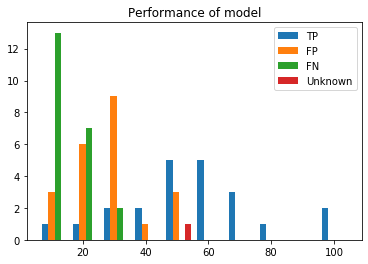

In [114]:
plt.hist([all_tp, all_fp, all_fn, unknown])
plt.legend(["TP", "FP", "FN", 'Unknown'])
plt.title('Performance of model');

In [115]:
1

1

# Look at the model predictions in napari

In [116]:

for i, t in tqdm(enumerate(train_loader.val_dataloader())):
    
    if i > 3:
        out = model(t)

        new_matches = [[i, int(m)] for i, m in enumerate(out['matches0'])]
        gt_matches = np.squeeze(t['all_matches'].numpy())
        n0_zxy = np.squeeze(t['keypoints0'])
        n1_zxy = np.squeeze(t['keypoints1'])

        gt_tracks_list = napari_tracks_from_match_list(gt_matches, n0_zxy, n1_zxy)
        new_tracks_list = napari_tracks_from_match_list(new_matches, n0_zxy, n1_zxy)

        v = napari.Viewer(ndisplay=3)

        v.add_points(n0_zxy, size=3, face_color='green', symbol='x', n_dimensional=True)
        v.add_points(n1_zxy, size=3, face_color='blue', symbol='o', n_dimensional=True)
        v.add_tracks(gt_tracks_list, head_length=2, name='gt matches')
        v.add_tracks(new_tracks_list, head_length=2, name='model matches')

        break

0it [00:00, ?it/s]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/napari/plugins/_plugin_manager.py:511: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


In [107]:
# new_matches

# Check the performance of the main tracking network on the tracklets

In [70]:
model_main = SuperGlueModel.load_from_checkpoint(PATH_TO_SUPERGLUE_MODEL)


In [151]:
model_main.to('cpu')
model_main.eval()

all_tp = []
all_fp = []
all_fn = []
all_unknown = []
for i, t in tqdm(enumerate(train_loader.train_dataloader())):
    
    out = model_main(t)
    
    new_matches = [[i, int(m)] for i, m in enumerate(out['matches0'])]
    gt_matches = np.squeeze(t['all_matches'].numpy())
    
    tp, fp, fn, unknown = accuracy_of_matches(gt_matches, new_matches)
    all_tp.append(tp)
    all_fp.append(fp)
    all_fn.append(fn)
    all_unknown.append(unknown)
    
    if i > 100:
        break

0it [00:00, ?it/s]

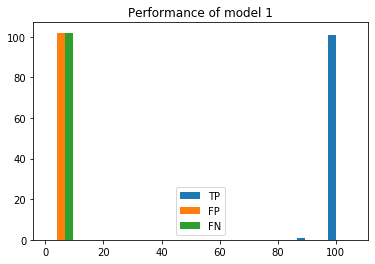

In [152]:
plt.hist([all_tp, all_fp, all_fn])
plt.legend(["TP", "FP", "FN"])
plt.title('Performance of model 1');

# Compare the performance of the baseline (null) model

In [75]:
from DLC_for_WBFM.utils.nn_utils.superglue import BipartiteSuperGlueStyleModel

In [142]:
model_null = BipartiteSuperGlueStyleModel()

In [149]:
all_tp = []
all_fp = []
all_fn = []
all_unknown = []
for i, t in tqdm(enumerate(train_loader.train_dataloader())):
    
    out = model_null(t)
    
    new_matches = [[i, int(m)] for i, m in enumerate(out['matches0'])]
    gt_matches = np.squeeze(t['all_matches'].numpy())
    
    tp, fp, fn, unknown = accuracy_of_matches(gt_matches, new_matches)
    all_tp.append(tp)
    all_fp.append(fp)
    all_fn.append(fn)
    all_unknown.append(unknown)
    
    if i > 100:
        break

0it [00:00, ?it/s]

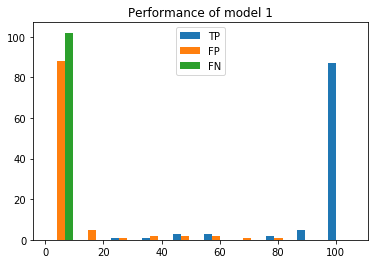

In [150]:
plt.hist([all_tp, all_fp, all_fn])
plt.legend(["TP", "FP", "FN"])
plt.title('Performance of model 1');

In [140]:
# %debug

In [146]:
tp

100

# Scratch for null models

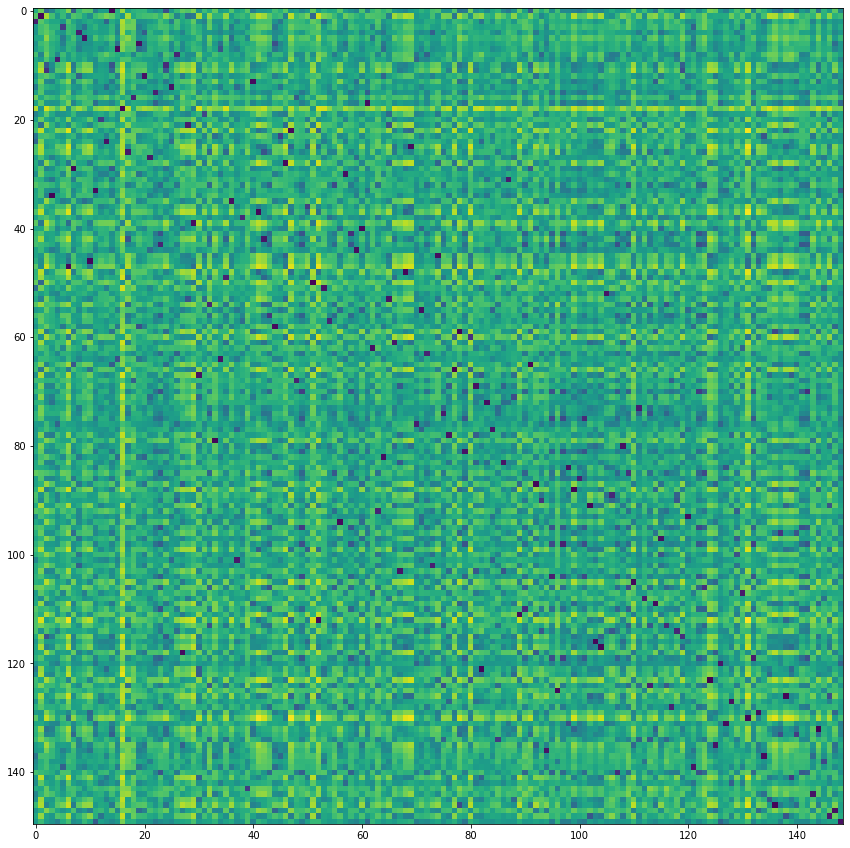

In [108]:
plt.figure(figsize=(15,15))
plt.imshow(out['distances'])

In [122]:
from DLC_for_WBFM.utils.general.distance_functions import dist2conf
from scipy.optimize import linear_sum_assignment

In [110]:
conf = dist2conf(out['distances'])

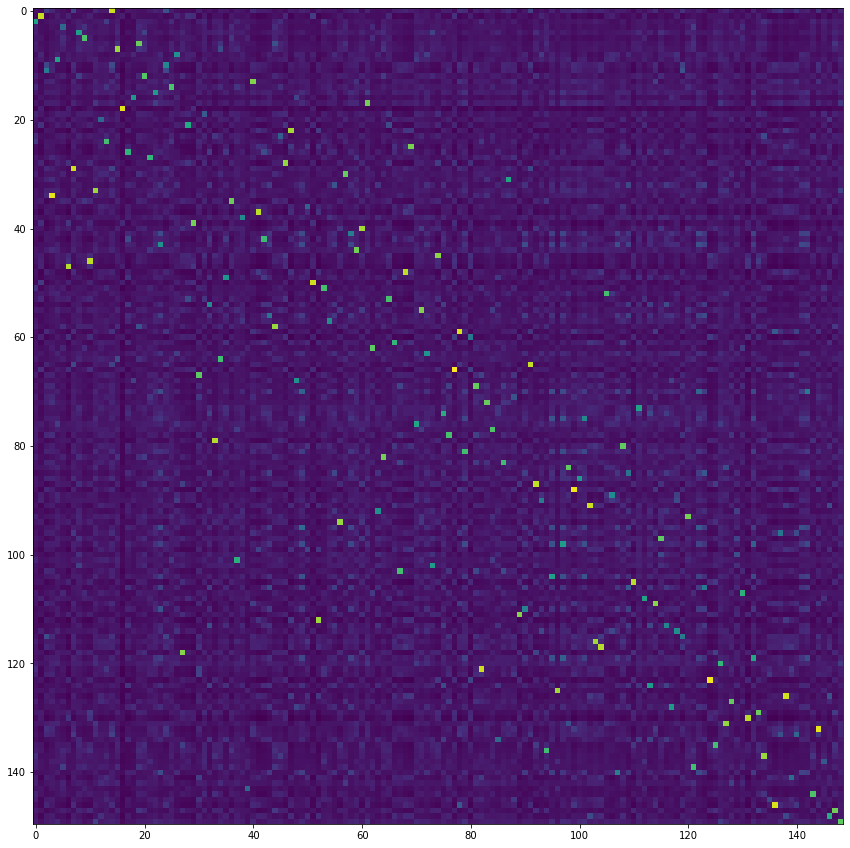

In [123]:
plt.figure(figsize=(15,15))
plt.imshow(conf)

In [125]:
matches = linear_sum_assignment(conf, maximize=True)

In [128]:
matches[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149])

In [129]:
matches[1]

array([ 14,   1,   0,   5,   8,   9,  19,  15,  26,   4,  24,   2,  20,
        40,  25,  22,  18,  61,  16,  31,  12,  28,  47,  45,  13,  69,
        17,  21,  46,   7,  57,  87,  55,  11,   3,  36,  50,  41,  38,
        29,  60,  58,  42,  23,  59,  74,  10,   6,  68,  35,  51,  53,
       105,  65,  32,  71,  43,  54,  44,  78,  80,  66,  62,  72,  34,
        91,  77,  30,  48,  81, 142,  88,  83, 111,  75, 101,  70,  84,
        76,  33, 108,  79,  64,  86,  98, 109, 100,  92,  99, 106,  93,
       102,  63, 120,  56,  49, 137, 115,  97, 122, 129,  37,  73,  67,
        95, 110, 123, 130, 112, 114,  90,  89,  52, 116, 118, 119, 103,
       104,  27, 132, 126,  82, 124, 113,  96, 138, 128, 117, 133, 131,
       127, 144, 140,  85, 125,  94, 134, 145, 121, 107, 139, 141,  39,
       143, 135, 136, 147, 146, 148])

# Scratch

In [3]:
fname = "/home/charles/dlc_stacks/worm1_for_students/project_config-workstation.yaml"
project_data1 = ProjectData.load_final_project_data_from_config(fname, to_load_frames=False)

INFO:projectDataLogger:Starting threads to read data...


Checking path /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31_worm1_Ch0/2022-01-27_19-31_worm1_Ch0bigtiff.btf on os posix...
Resolved path to /scratch/neurobiology/zimmer/ulises/wbfm/20220127/data/worm1/2022-01-27_19-31_worm1_Ch0/2022-01-27_19-31_worm1_Ch0bigtiff.btf
File for mode automatic exists at precendence: 1/3
Read data from: /home/charles/dlc_stacks/worm1_for_students/3-tracking/postprocessing/combined_3d_tracks---12.h5


INFO:projectDataLogger:Read all data


Project data for directory:
/home/charles/dlc_stacks/worm1_for_students 
Found the following data files:
============Raw========================
red_data:                 True
green_data:               True
============Annotations================
behavior_annotations:     True
============Training================
df_training_tracklets:    True
============Segmentation===============
raw_segmentation:         True
colored_segmentation:     True
============Traces=====================
red_traces:               True
green_traces:             True



In [6]:
# project_data1.df_all_tracklets

In [7]:
# project_data1.red_traces

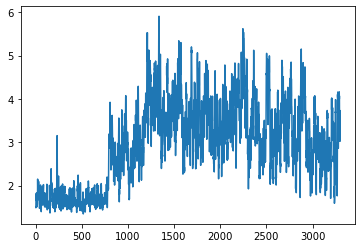

In [29]:
line = project_data1.final_tracks['neuron_001']['z'].plot().lines[0]

In [30]:
line.remove()

In [31]:
line